In [7]:
import numpy as np
import random
import torch
import dataloader
import matplotlib.pyplot as plt
import sim2
import math
from typing import Dict
import os
import librosa
import mfcc_vae_1 as vae
import mfcc

In [8]:
QUIET = True
def qprint(*args, **kwargs):
    if not QUIET:
        print(*args, **kwargs)

class ClusterFilterAug3:
    def __init__(self, max_clusters, max_weight, embedding_size, thresh):
        self.means = np.zeros((max_clusters, embedding_size))
        self.weights = np.zeros((max_clusters,))
        self.max_weight = max_weight
        self.max_clusters = max_clusters
        self.base_radius = thresh

    def insert(self, mean: np.ndarray, std: np.ndarray) -> bool:
        assert mean.shape == self.means.shape[1:] and mean.shape == std.shape and self.means.shape[0] == self.max_clusters and self.weights.shape == (self.max_clusters,)
        l2_norm = np.sqrt(np.sum((self.means - mean) ** 2, axis = 1))
        close = l2_norm <= np.sqrt(self.weights) * self.base_radius

        if np.any(close):
            center = (np.sum((self.means[close].T * self.weights[close]).T, axis = 0) + mean) / (np.sum(self.weights[close]) + 1)
            weight = min(np.sum(self.weights[close]) + 1, self.max_weight)
            self.means = np.concatenate([
                self.means[~close],
                [ center ],
                np.zeros((self.means.shape[0] - (np.sum(~close) + 1), self.means.shape[1])),
            ])
            self.weights = np.concatenate([
                self.weights[~close],
                [ weight ],
                np.zeros((self.weights.shape[0] - (np.sum(~close) + 1),)),
            ])
            return False
        else:
            self.means = np.concatenate([
                self.means[1:],
                [ mean ],
            ])
            self.weights = np.concatenate([
                self.weights[1:],
                [ 1 ],
            ])
            return True

def load_sounds(path: str, *, min_length: float = 0, max_length: float = math.inf, mult_length: float = None, max_silence_ratio: float = None) -> Dict[str, np.ndarray]:
    res = { cls: [] for cls in sorted(os.listdir(path)) }
    for cls, entries in res.items():
        for file in sorted(os.listdir(f'{path}/{cls}')):
            clip, sr = librosa.load(f'{path}/{cls}/{file}', sr = dataloader.UNIFORM_SAMPLE_RATE)
            assert sr == dataloader.UNIFORM_SAMPLE_RATE, sr
            assert len(clip.shape) == 1, clip.shape
            if mult_length is not None:
                assert len(clip) % (mult_length * sr) == 0, f'{path}/{cls}/{file} not a multiple of {mult_length}s'

            if len(clip) < min_length * sr:
                qprint(f'  omitting {path}/{cls}/{file} -- too short ({len(clip) / sr:0.2f}s < {min_length:0.2f}s)')
                continue
            if len(clip) > max_length * sr:
                qprint(f'  omitting {path}/{cls}/{file} -- too long ({len(clip) / sr:0.2f}s > {max_length:0.2f}s)')
                continue

            if max_silence_ratio is not None and np.mean(clip == 0) > max_silence_ratio:
                qprint(f'  omitting {path}/{cls}/{file} -- too much silence')
                continue

            entries.append(clip)
    return { k: v for k,v in res.items() if len(v) > 0 }

def random_contract(x: np.ndarray, s: int) -> np.ndarray:
    if x.shape[0] <= s: return x
    t = random.randrange(x.shape[0] - s)
    return x[t:t+s]
def random_extend(x: np.ndarray, s: int) -> np.ndarray:
    if x.shape[0] >= s: return x
    t = random.randrange(s - x.shape[0])
    res = np.zeros((s,))
    res[t:t+x.shape[0]] = x
    return res

def create_fade(size, *, fade_duration, sr):
    t = min(round(fade_duration * sr), round(size / 4))
    return np.concat([
        np.linspace(0, 1, t),
        np.ones((size - 2 * t,)),
        np.linspace(1, 0, t),
    ])

def energy_peak(x: np.array, *, radius: int):
    kernel = np.concat([
        np.linspace(0, 1, radius + 2)[1:-1],
        [1],
        np.linspace(1, 0, radius + 2)[1:-1],
    ])
    return np.argmax(np.convolve(x**2, kernel, mode = 'same'))

def energy_chunks(x: np.array, *, size: int, radius: int, count: int):
    res = []
    x = np.copy(x)
    half = size // 2
    e = np.concat([np.zeros((half,)), x, np.zeros((half,))])
    for _ in range(count):
        p = energy_peak(x, radius = radius)
        res.append(e[p : p + size])
        x[max(0, p - half) : min(len(x), p - half + size)] = 0
    return np.array(res)

def chunks(x: np.array, *, size: int, overlaps: int) -> np.array:
    assert len(x) >= size
    p = 0
    s = round(size / (1 + overlaps))
    res = []
    while p + size <= len(x):
        res.append(x[p:p+size])
        p += s
    return np.array(res)


EVENTS = [
    '/home/devin/Downloads/dog-events/',
    '/home/devin/Downloads/misc-events/',
]
BACKGROUNDS = [
    '/home/devin/Downloads/edansa-events/',
]

max_silence_ratio = 0.1
clip_duration = 30

backgrounds = dict(sum((list(load_sounds(path, min_length = dataloader.SAMPLE_DURATION_SECS, mult_length = dataloader.SAMPLE_DURATION_SECS, max_silence_ratio = max_silence_ratio).items()) for path in sorted(BACKGROUNDS)), start = []))
events = dict(sum((list(load_sounds(path, max_length = clip_duration, max_silence_ratio = max_silence_ratio).items()) for path in sorted(EVENTS)), start = []))

print(f'backgrounds: {({ k: len(v) for k,v in backgrounds.items() })}\n')
print(f'events: {({ k: len(v) for k,v in events.items() })}\n')

backgrounds: {'Airc': 373, 'Bug': 425, 'Mach': 28, 'Rain': 143, 'Water': 14, 'Wind': 928}

events: {'Australian cattle dog': 215, 'Australian shepherd': 162, 'Dachsund': 38, 'German shorthair pointer': 156, 'Labrador mix': 35, 'Springer spaniel': 19, 'Aircraft': 223, 'BackgroundSounds': 3379, 'Basketball': 10, 'Beeping': 21, 'Bell': 143, 'BirdChirp': 278, 'CarDoor': 78, 'Cat': 40, 'Clapping': 85, 'Coughing': 125, 'Cow': 32, 'Crow': 118, 'Dog': 568, 'Drums': 1259, 'Engine': 1034, 'Frog': 721, 'GlassBreak': 218, 'GunNoise': 193, 'HandSaw': 70, 'Horn': 259, 'Insects': 446, 'Jackhammer': 619, 'Laughing': 36, 'Noise': 449, 'PowerTool': 296, 'Rooster': 51, 'Scream': 6, 'Sheep': 38, 'Siren': 486, 'Sneezing': 11, 'Thunder': 111, 'Train': 206, 'Unknown': 75, 'VehicleExhaust': 72, 'Whistle': 5, 'Whistling': 3, 'Wind': 1}



In [9]:
event_freqs = ['Frog:1', 'Rooster:1', 'Aircraft:1']

event_freqs = { x[:x.index(':')]: float(x[x.index(':')+1:]) for x in event_freqs }
if '*' in event_freqs:
    event_freqs = { **event_freqs, **{ x: event_freqs['*'] for x in events.keys() if x not in event_freqs } }
    del event_freqs['*']
event_freqs = { k: v for k, v in event_freqs.items() if v > 0 }
if len(event_freqs) == 0: event_freqs = { x: 1 for x in events.keys() }
for x in event_freqs.keys():
    if x not in events:
        raise RuntimeError(f'unknown event type: "{x}"')
def pick_event():
    t = sum(event_freqs.values())
    r = random.random()
    p = 0
    e = None
    for event, weight in event_freqs.items():
        e = event
        p += weight / t
        if r < p: break
    return e

print(f'event freqs: {event_freqs}\n')
for x in [x for x in events.keys() if x not in event_freqs]:
    del events[x]

event freqs: {'Frog': 1.0, 'Rooster': 1.0, 'Aircraft': 1.0}



In [10]:
max_clusters = 64
max_weight = 16
filter_thresh = 0.45
chunk_count = 4
radius = 256
vote_thresh = 0.0

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
encoder = vae.Encoder(embedding_size = 16).to(device)
encoder.load_state_dict(torch.load('mfcc-untested-1/encoder-F16-A0.9-E256-L171.pt', weights_only = True))
encoder.eval()

f = ClusterFilterAug3(max_clusters, max_weight, encoder.embedding_size, filter_thresh)
def vote_retain(x: np.ndarray) -> bool:
    votes = []
    # for seg in chunks(x, size = dataloader.UNIFORM_SAMPLE_RATE * dataloader.SAMPLE_DURATION_SECS, overlaps = args.overlaps):
    for seg in energy_chunks(x, size = dataloader.UNIFORM_SAMPLE_RATE * dataloader.SAMPLE_DURATION_SECS, count = chunk_count, radius = radius):
        with torch.no_grad():
            mean, std = encoder.forward(torch.tensor(mfcc.mfcc_spectrogram_for_learning(seg, dataloader.UNIFORM_SAMPLE_RATE)[np.newaxis,:], dtype = torch.float).to(device))
            votes.append(f.insert(mean.cpu().numpy().squeeze(), std.cpu().numpy().squeeze()))
    return np.mean(votes) > vote_thresh

In [11]:
event_prob = 0.75
bg_change_prob = 0.1
fade_duration = 1
background_scale = 0

encodings = { k: [] for k in event_freqs.keys() }
encodings['None'] = []
input_events = { x: 0 for x in [None] + list(event_freqs.keys()) }
output_events = input_events.copy()
background_class = None
clip_len = dataloader.UNIFORM_SAMPLE_RATE * clip_duration
for i in range(200):
    if background_class is None or random.random() < bg_change_prob:
        background_class = random.choice(sorted(backgrounds.keys()))
    background = random.choice(backgrounds[background_class])
    clip = np.tile(background, math.ceil(clip_len / len(background)))[:clip_len] # avoid random_contract to prevent transitions in inference chunks
    assert clip.shape == (clip_len,), clip.shape

    clip *= background_scale
    
    event_class = None
    if random.random() < event_prob:
        event_class = pick_event()
        event = random.choice(events[event_class])
        event = event * create_fade(len(event), fade_duration = fade_duration, sr = dataloader.UNIFORM_SAMPLE_RATE)
        event = random_contract(random_extend(event, clip_len), clip_len)
        clip += event

    for seg in energy_chunks(clip, size = dataloader.UNIFORM_SAMPLE_RATE * dataloader.SAMPLE_DURATION_SECS, count = chunk_count, radius = radius):
        with torch.no_grad():
            mean, std = encoder.forward(torch.tensor(mfcc.mfcc_spectrogram_for_learning(seg, dataloader.UNIFORM_SAMPLE_RATE)[np.newaxis,:], dtype = torch.float).to(device))
            encodings[str(event_class)].append(mean.cpu().numpy().squeeze())

# PCA

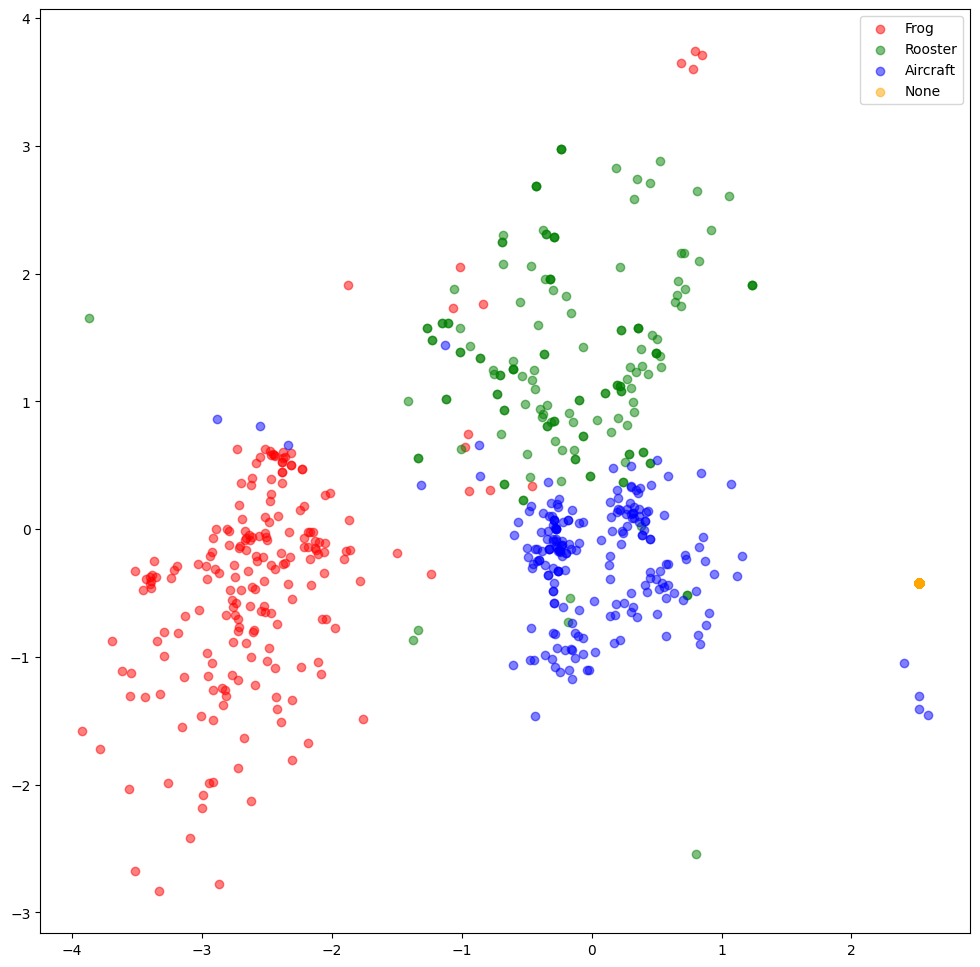

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit_transform([x for xs in encodings.values() for x in xs])
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()
labels = list(encodings.keys())
colors = ['red', 'green', 'blue', 'orange', 'cyan', 'black', 'yellow']
for label, values in { k: pca.transform(v) for k, v in encodings.items() }.items():
    idx = labels.index(label)
    ax.scatter(*values.T, color = colors[idx], alpha = 0.5, label = label)
plt.legend()

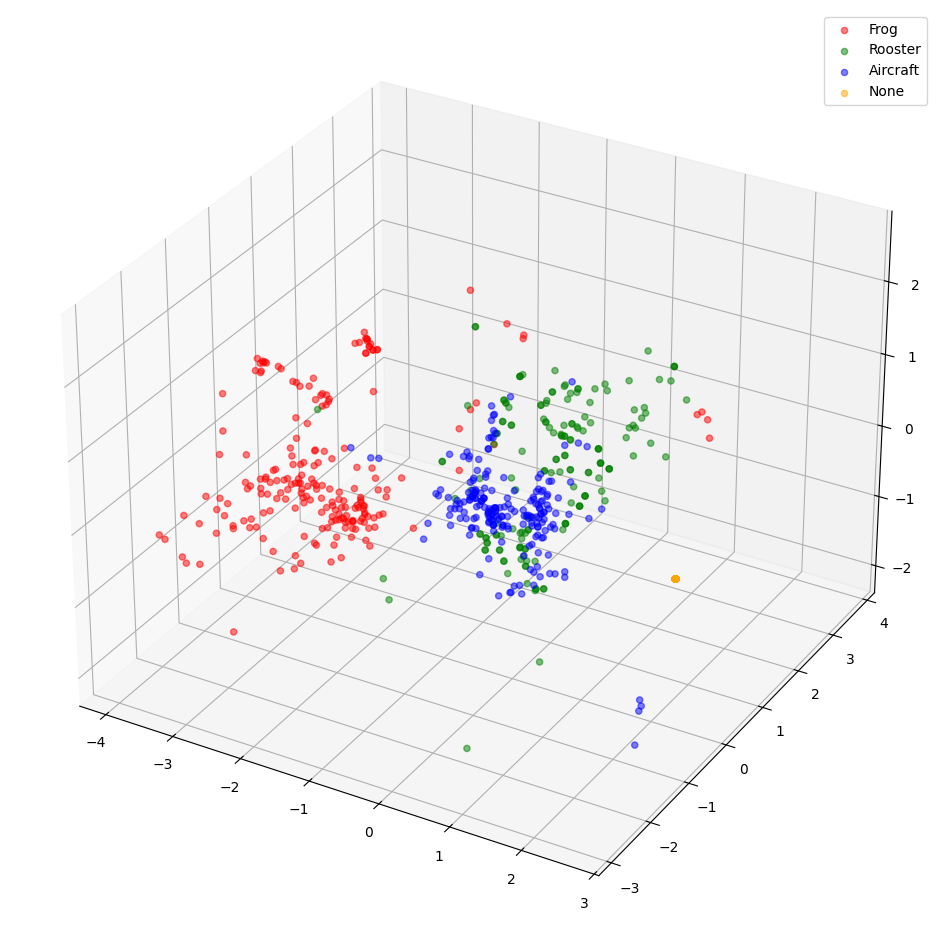

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca.fit_transform([x for xs in encodings.values() for x in xs])
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection = '3d')
labels = list(encodings.keys())
colors = ['red', 'green', 'blue', 'orange', 'cyan', 'black', 'yellow']
for label, values in { k: pca.transform(v) for k, v in encodings.items() }.items():
    idx = labels.index(label)
    ax.scatter(*values.T, color = colors[idx], alpha = 0.5, label = label)
plt.legend()

# UMAP

/home/devin/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/devin/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/devin/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/devin/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/devin/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

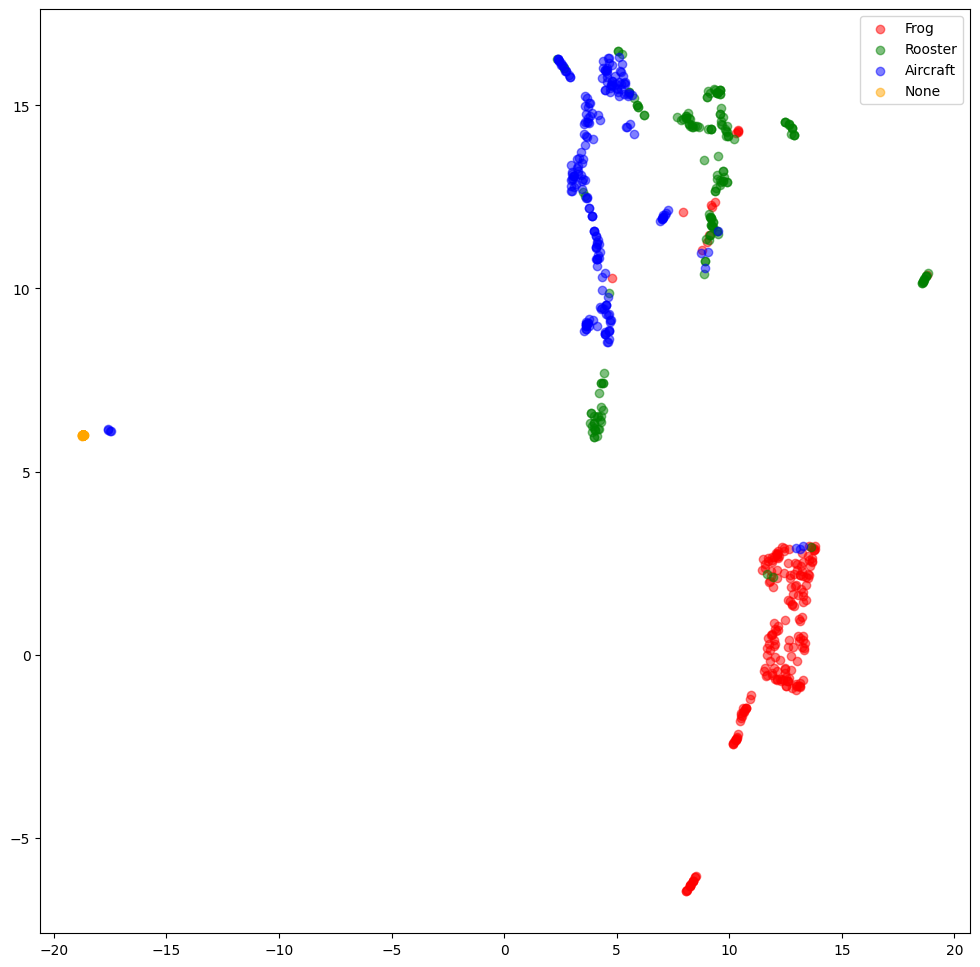

In [14]:
from umap import UMAP
umap = UMAP(n_components = 2)
umap.fit_transform([x for xs in encodings.values() for x in xs])
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()
labels = list(encodings.keys())
colors = ['red', 'green', 'blue', 'orange', 'cyan', 'black', 'yellow']
for label, values in { k: umap.transform(v) for k, v in encodings.items() }.items():
    idx = labels.index(label)
    ax.scatter(*values.T, color = colors[idx], alpha = 0.5, label = label)
plt.legend()

/home/devin/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/devin/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/devin/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/devin/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/devin/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  

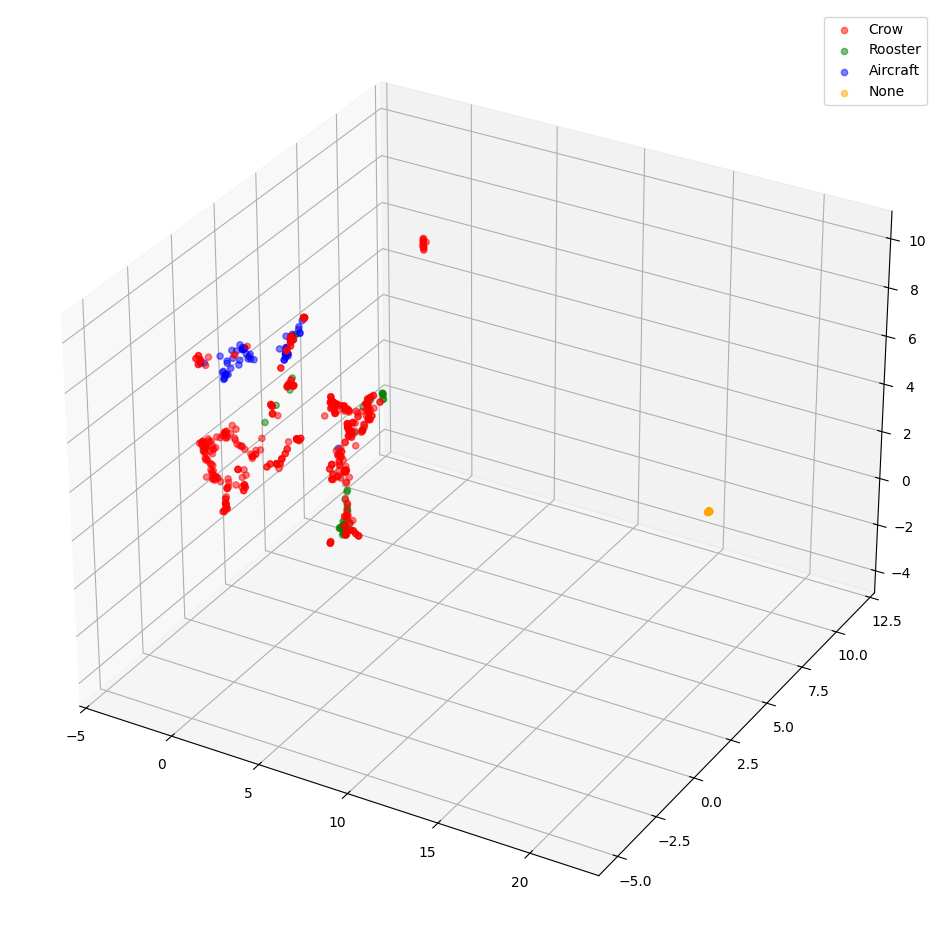

In [12]:
from umap import UMAP
umap = UMAP(n_components = 3)
umap.fit_transform([x for xs in encodings.values() for x in xs])
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection = '3d')
labels = list(encodings.keys())
colors = ['red', 'green', 'blue', 'orange', 'cyan', 'black', 'yellow']
for label, values in { k: umap.transform(v) for k, v in encodings.items() }.items():
    idx = labels.index(label)
    ax.scatter(*values.T, color = colors[idx], alpha = 0.5, label = label)
plt.legend()